# Look at the big picture.


## Libraries

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from statistics import median
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext pycodestyle_magic

In [3]:
# Activamos las alertas de estilo
%pycodestyle_on

## Performance Metric

In [2]:
def performance(y_true: list, y_pred: list) -> float:
    """

    """

    CF = [1 for _ in y_true if y_pred > y_true] / len(y_pred) * 100
    RMSE = mean_squared_errors(y_true, y_pred)
    sEMSE = RMSE / median(y_true)
    metric = (0.7 * rRMSE) + (0.3 * (1 - CF))

    return metric

# Get the data

In [3]:
dtypes = {
    "fecha": "string",
    "id": "category",
    "visitas": "Int64",
    "categoria_uno": "category",
    "categoria_dos": "category",
    "estado": "category",
    "precio": "Float64",
    "dia_atipico": "category",
    "campaña": "category",
    "antiguedad": "Int64",
    "unidades_vendidas": "Int64"    
}

# Read the data
data = pd.read_csv('./data/Modelar_UH2021.txt', delimiter="|", dtype=dtypes, decimal=',')

## Overview the data

In [4]:
data.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75,No Rotura,NaN,0,0,5241,0
1,1/6/2015 0:00:00,23910,5,C,170,No Rotura,6.07,0,0,5241,3
2,1/6/2015 0:00:00,24306,13,A,46,No Rotura,NaN,0,0,<NA>,0
3,1/6/2015 0:00:00,24306,13,A,46,No Rotura,NaN,0,0,<NA>,0
4,1/6/2015 0:00:00,27144,15,E,230,No Rotura,NaN,0,0,4064,0


In [5]:
data.isnull().sum()

fecha                      0
id                         0
visitas                    0
categoria_uno              0
categoria_dos           5844
estado                     0
precio               2642911
dia_atipico                0
campaña                    0
antiguedad            874165
unidades_vendidas          0
dtype: int64

In [6]:
data.describe()

,visitas,precio,antiguedad,unidades_vendidas
count,4.045022e+06,1.402111e+06,3.170857e+06,4.045022e+06
mean,1.721371e+02,3.424319e+01,1.011114e+03,4.693434e+00
std,6.889116e+02,2.330943e+01,7.162509e+02,2.237403e+01
min,0.000000e+00,3.570000e+00,1.260000e+02,0.000000e+00
25%,7.000000e+00,1.652000e+01,5.240000e+02,0.000000e+00
50%,3.500000e+01,2.689000e+01,7.950000e+02,0.000000e+00
75%,1.300000e+02,4.535000e+01,1.244000e+03,3.000000e+00
max,1.200450e+05,1.757800e+02,5.310000e+03,4.881000e+03


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045022 entries, 0 to 4045021
Data columns (total 11 columns):
 #   Column             Dtype   
---  ------             -----   
 0   fecha              string  
 1   id                 category
 2   visitas            Int64   
 3   categoria_uno      category
 4   categoria_dos      category
 5   estado             category
 6   precio             float64 
 7   dia_atipico        category
 8   campaña            category
 9   antiguedad         Int64   
 10  unidades_vendidas  Int64   
dtypes: Int64(3), category(6), float64(1), string(1)
memory usage: 196.9 MB


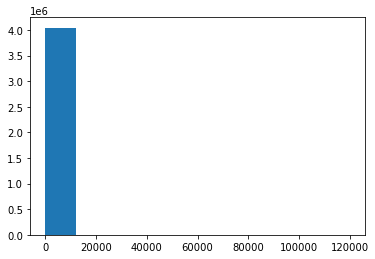

In [8]:
fix, ax = plt.subplots()

ax.hist(data.visitas)
plt.show()

# Discover and visualize the data to gain insights

In [9]:
data.groupby(["categoria_uno","categoria_dos"])["precio"].count()

categoria_uno  categoria_dos
A              10                 0
               101                0
               103              831
               105                0
               108                0
                               ... 
O              93                 0
               95                 0
               96                 0
               97                 0
               98                 0
Name: precio, Length: 2366, dtype: int64

# Prepare the data for Machine Learning algorithms

## Preprocessing functions 

### Time format

In [12]:
class time_format(BaseEstimator, TransformerMixin):

    def __init__(self, document='Modelar'):
        self.document = document

    def fit(self, X, y=None):
        # nothing else to do
        return self


    def transform(self, data):
        """
        Take the dataframe and trate the 'fecha' attribute depending of the document.
        If it is the 'Modelar' document, the variable will be equal to the content
        before the first space.
        If it it the 'Estimar' document, the variable will be transformed to the
        original format

        Original Format: 'DD/MM/AAAA' in (text format)


        """

        temp = ''

        if self.document == 'Modelar':
            data['fecha'] = pd.to_datetime(data['fecha'],infer_datetime_format=True).apply(lambda x : x.strftime('%d/%m/%Y'))
        elif self.document == 'Estimar':
            # agregar la modificación para el documento Estimar
            data['fecha']
        else:
            print('Unknown document!!!')


        return data

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045022 entries, 0 to 4045021
Data columns (total 11 columns):
 #   Column             Dtype   
---  ------             -----   
 0   fecha              string  
 1   id                 category
 2   visitas            Int64   
 3   categoria_uno      category
 4   categoria_dos      category
 5   estado             category
 6   precio             float64 
 7   dia_atipico        category
 8   campaña            category
 9   antiguedad         Int64   
 10  unidades_vendidas  Int64   
dtypes: Int64(3), category(6), float64(1), string(1)
memory usage: 196.9 MB


### Drop duplicates

In [10]:
class drop_dup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        # nothing else to do
        return self


    def transform(self, data):
        """
        Take the dataframe and return the dataframe without duplicates.

        """

        return data.drop_duplicates()

### Coding "Antiguedad" attribute

In [16]:
class replace_state(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        # nothing else to do
        return self


    def transform(self, data):
        """
        Take the dataframe and return the dataframe without duplicates.

        """
        
        data.estado.replace({'No Rotura': 1, 'Rotura': -1, 'Tránsito': 0}, inplace=True)
        
        return data

### Data Preprocessing Pipeline

In [17]:
from sklearn.pipeline import Pipeline

data_prep_pipeline = Pipeline([
         ('drop_dup', drop_dup()),
         ('state_encoding', replace_state()),
         ('time_format', time_format(document='Modelar'))         
])

data_prep_pipeline.fit_transform(data)

C:\Users\reyne\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-12-2b0b05b711fe>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fecha'] = pd.to_datetime(data['fecha'],infer_datetime_format=True).apply(lambda x : x.strftime('%d/%m/%Y'))


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,06/01/2015,21972,0,C,75,1,NaN,0,0,5241,0
1,06/01/2015,23910,5,C,170,1,6.07,0,0,5241,3
2,06/01/2015,24306,13,A,46,1,NaN,0,0,<NA>,0
4,06/01/2015,27144,15,E,230,1,NaN,0,0,4064,0
5,06/01/2015,27504,7,C,157,1,NaN,0,0,5261,0
...,...,...,...,...,...,...,...,...,...,...,...
4045016,30/09/2016,456982,6575,F,336,1,81.28,0,0,<NA>,30
4045017,30/09/2016,457416,1395,F,336,1,50.38,0,0,130,9
4045018,30/09/2016,457422,1080,F,336,-1,NaN,0,0,130,0
4045019,30/09/2016,458650,1385,K,340,1,NaN,0,0,126,0


In [9]:
data.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,06/01/2015,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,06/01/2015,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3
2,06/01/2015,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,06/01/2015,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,06/01/2015,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


## Outliers

No debe haber outliers


# Select a model and train it

# Fine-tune your model

# Present your solution